In [1]:
%pylab inline
import multiprocessing as mp
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [3]:
from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.8,5201)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'TNG_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "TNG")()
basic_agb = AGB_feedback()
getattr(basic_agb, "TNG_net")()

# Use all elements that are traced
elements_to_trace = ['H','He','C','N','O','Ne','Mg','Si','Fe']

# Producing the SSP birth elemental fractions (here we use solar)
solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

In [4]:
# yieldset default
a.yield_table_name_sn2 = 'TNG_net'#'chieffi04_net'#'TNG_net'
a.yield_table_name_agb = 'TNG_net'#'Karakas16_net'#Ventura_net'#'TNG_net'
a.yield_table_name_1a = 'TNG'#'Seitenzahl'#'TNG'

# imf parameters
a.only_net_yields_in_process_tables = True
a.imf_type_name = 'Chabrier_TNG'
#default
a.high_mass_slope = -2.3
a.imf_parameter = (0.852464,0.237912,0.079,0.69, a.high_mass_slope)
a.mmin = 0.1
a.mmax = 100
# 100,000,000 mass steps are smooth enough for 1000 time steps
a.mass_steps = 200000 #2000 # 200000
a.sn2mmin = 8.
a.sn2mmax = 100.
a.bhmmin = float(a.sn2mmax) ## maximum of hypernova
a.bhmmax = float(a.mmax) ## maximum of the IMF

# sn1a delay parameters for maoz
#default
a.N_0 = 0.0012882#np.power(10,-2.89)
a.sn1a_time_delay = 0.04#np.power(10,-0.8)
#alternative
#a.N_0 = np.power(10,-3.49)
#a.sn1a_time_delay = np.power(10,-0.88)

a.sn1a_exponent = 1.12
a.dummy = 0.0
a.sn1a_parameter = [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy]
######################## END OF SETTING CHEMPY PARAMETER FOR SSP YIELD TABLE PRODUCTION

In [5]:
from Chempy.wrapper import SSP_wrap

basic_ssp = SSP_wrap(a)

In [6]:
basic_ssp.calculate_feedback(0.02,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

In [7]:
differential_table = True # True is the default Chempy behaviour

x = basic_ssp.agb_table
y = basic_ssp.sn1a_table
z = basic_ssp.sn2_table
s = basic_ssp.bh_table
d = basic_ssp.table

#x2 = x+ (d['mass_of_ms_stars_dying']-x['mass_in_remnants'])

u = np.zeros_like(x)
names = list(u.dtype.names)

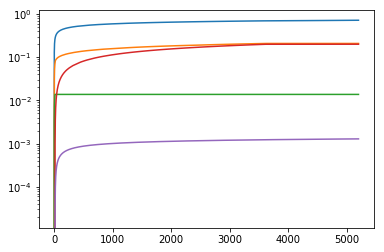

In [8]:
plt.plot(np.cumsum(d['mass_of_ms_stars_dying']))
plt.plot(np.cumsum(d['mass_in_remnants']))
plt.plot(np.cumsum(d['sn2']))
plt.plot(np.cumsum(d['pn']))
plt.plot(np.cumsum(d['sn1a']))
plt.yscale('log')

In [9]:
ejected_mass = d['mass_of_ms_stars_dying']-d['mass_in_remnants']

d2 = np.copy(d)
for e,el in enumerate(elements_to_trace):
    d2[el] = d[el]+ejected_mass*solar_fractions[e]

In [10]:
final_els=[]
for el in elements_to_trace:
    final_els.append(np.sum(d2[el]))

In [11]:
for j,jtem in enumerate(names):
    u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
for el in elements_to_trace:
    d[el] = u[el]

In [12]:
from Chempy.weighted_yield import imf_mass_fraction_non_nativ
invimf = basic_ssp.inverse_imf
imf = basic_ssp.imf

sn2_mass=imf_mass_fraction_non_nativ(imf.dm,imf.x,a.sn2mmin,a.sn2mmax)
agb_mass = imf_mass_fraction_non_nativ(imf.dm,imf.x,a.agbmmin,a.agbmmax)
sn1a_mass = -np.sum(y['mass_in_remnants'])
sn1a_mass = np.sum(d['sn2'])*1.3743416

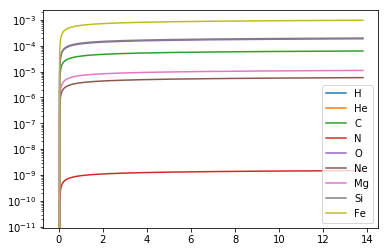

In [13]:
for el in elements_to_trace:
    plt.plot(time_steps,np.cumsum(y[el]),label=el)
plt.legend()
plt.yscale('log')

In [14]:
full_agb,full_sn2,full_sn1a = [np.zeros(len(elements_to_trace)) for _ in range(3)]
for e,el in enumerate(elements_to_trace):
        full_agb[e]=np.sum(x[el])+(agb_mass-np.sum(x['mass_in_remnants']))*solar_fractions[e]
        full_sn2[e]=np.sum(z[el])+(sn2_mass-np.sum(z['mass_in_remnants']))*solar_fractions[e]
        full_sn1a[e]=np.sum(y[el])

In [15]:
# np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/yields_plot_WrongYields.npz',
#         agb=full_agb,sn2=full_sn2,sn1a=full_sn1a,elements=elements_to_trace)

In [17]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/yields_plot_TNG.npz',
        agb=full_agb,sn2=full_sn2,sn1a=full_sn1a,elements=elements_to_trace)

In [20]:
yieldT=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/old/TNG_Abun2/yields_plot_TNG.npz')
yieldW=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/old/TNG_Abun2/yields_plot_WrongYields.npz')

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


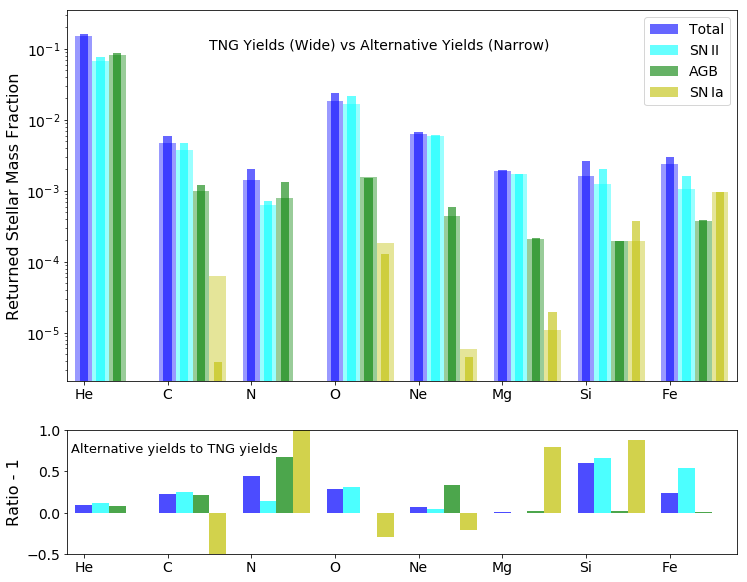

In [22]:
from matplotlib import gridspec

# plot it
fig = plt.figure(figsize=(12, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])

width=0.2
al1=0.4
yields=yieldT
xax=np.arange(len(elements_to_trace))
ax0.bar(xax,yields.f.agb+yields.f.sn2+yields.f.sn1a,width,color='blue',alpha=al1)
ax0.bar(xax+width,yields.f.sn2,width,color='cyan',alpha=al1)
ax0.bar(xax+2*width,yields.f.agb,width,color='g',alpha=al1)
ax0.bar(xax+3*width,yields.f.sn1a,width,color='y',alpha=al1)
width2=0.1
yields=yieldW
al2=0.6
ax0.bar(xax,yields.f.agb+yields.f.sn2+yields.f.sn1a,width2,color='blue',alpha=al2,label='Total')
ax0.bar(xax+width,yields.f.sn2,width2,color='cyan',alpha=al2,label=r'$\mathrm{SN\,II}$')
ax0.bar(xax+width*2.,yields.f.agb,width2,color='g',alpha=al2,label='AGB')
ax0.bar(xax+width*3.,yields.f.sn1a,width2,color='y',alpha=al2,label=r'$\mathrm{SN\,Ia}$')
ax0.bar(elements_to_trace,-full_agb)
plt.legend(fontsize=14)
ax0.set_ylim([2.1e-6,0.35])
ax0.set_xlim([0.8,8.8])
ax0.set_yscale('log');
ax0.set_ylabel('Returned Stellar Mass Fraction',fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)

ax0.text(2.5,0.1,'TNG Yields (Wide) vs Alternative Yields (Narrow)',fontsize=14)

ax1 = plt.subplot(gs[1])
width=0.2
al1=0.7
all_yield = (yieldW.f.agb+yieldW.f.sn2+yieldW.f.sn1a)/(yieldT.f.agb+yieldT.f.sn2+yieldT.f.sn1a)
agb=yieldW.f.agb/yieldT.f.agb
sn2=yieldW.f.sn2/yieldT.f.sn2
sn1a=yieldW.f.sn1a/yieldT.f.sn1a
xax=np.arange(len(elements_to_trace))
ax1.bar(xax,all_yield-1,width,color='blue',label='Total',alpha=al1)
ax1.bar(xax+width,sn2-1,width,color='cyan',label='SN\,II',alpha=al1)
ax1.bar(xax+2*width,agb-1,width,color='g',label='AGB',alpha=al1)
ax1.bar(xax+3*width,sn1a-1,width,color='y',label='SN\,Ia',alpha=al1)
ax1.plot(elements_to_trace,np.ones(len(elements_to_trace))*-10.)
ax1.set_ylim([-0.5,1])
ax1.text(.85,0.73,'Alternative yields to TNG yields',fontsize=13)
ax1.set_xlim([0.8,8.8])
ax1.set_ylabel('Ratio - 1',fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('/home/oliverphilcox/ChempyMulti/Plots_New/Mass_Fraction_Comparison.pdf',bbox_inches='tight')